# CSV Statistics Analysis

This notebook analyzes prediction statistics from a CSV file containing POI (Point of Interest) predictions.


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import ast
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

## Load and Prepare Data

In [2]:
# Set the folder path containing CSV files
folder_path = "/leonardo_work/IscrC_LLM-Mob/LLM-Mob-As-Mobility-Interpreter/results/results_mixtral_8x7b_with_geom/"  # Modify this path to point to your CSV files folder

import os
import glob

# Find all CSV files matching the pattern dati_YEAR_*.csv
csv_pattern = os.path.join(folder_path, "dati_*.csv")
csv_files = glob.glob(csv_pattern)
csv_files.sort()  # Sort files for consistent processing order

print(f"Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"  - {os.path.basename(file)}")

# Load and combine all CSV files
df_list = []
file_info = []

for file_path in csv_files:
    try:
        # Extract year from filename (after first underscore)
        filename = os.path.basename(file_path)
        year = filename.split('_')[1]
        
        df_temp = pd.read_csv(file_path)
        df_temp['year'] = year  # Add year column
        df_temp['source_file'] = filename  # Add source file info
        
        df_list.append(df_temp)
        file_info.append({'file': filename, 'year': year, 'records': len(df_temp)})
        
        print(f"Loaded {filename}: {len(df_temp)} records (Year: {year})")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Combine all dataframes
if df_list:
    df = pd.concat(df_list, ignore_index=True)
    print(f"\nCombined dataset shape: {df.shape}")
    
    # Show file distribution
    print(f"\nRecords per file:")
    for info in file_info:
        print(f"  {info['file']}: {info['records']:,} records")
    
    print(f"\nRecords per year:")
    year_counts = df['year'].value_counts().sort_index()
    for year, count in year_counts.items():
        print(f"  {year}: {count:,} records")
        
else:
    print("No CSV files found or loaded successfully!")
    df = pd.DataFrame()

print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Found 7 CSV files:
  - dati_2014_pred_20250824_224111.csv
  - dati_2015_pred_20250823_170255.csv
  - dati_2016_pred_20250825_094050.csv
  - dati_2017_pred_20250822_091800.csv
  - dati_2018_pred_20250822_090308.csv
  - dati_2019_pred_20250822_090833.csv
  - dati_2020_pred_20250822_091241.csv
Loaded dati_2014_pred_20250824_224111.csv: 65891 records (Year: 2014)
Error loading /leonardo_work/IscrC_LLM-Mob/LLM-Mob-As-Mobility-Interpreter/results/results_mixtral_8x7b_with_geom/dati_2015_pred_20250823_170255.csv: Error tokenizing data. C error: Expected 8 fields in line 47502, saw 10

Loaded dati_2016_pred_20250825_094050.csv: 70264 records (Year: 2016)
Error loading /leonardo_work/IscrC_LLM-Mob/LLM-Mob-As-Mobility-Interpreter/results/results_mixtral_8x7b_with_geom/dati_2017_pred_20250822_091800.csv: Error tokenizing data. C error: Expected 8 fields in line 10002, saw 10

Error loading /leonardo_work/IscrC_LLM-Mob/LLM-Mob-As-Mobility-Interpreter/results/results_mixtral_8x7b_with_geom/dati_201

,card_id,cluster,history,current_poi,prediction,ground_truth,reason,hit,processing_time,status,year,source_file
0,040002523F3885,3,"['San Fermo', 'Santa Anastasia', 'Teatro Roman...",Arena,"['Verona Tour', 'Museo Lapidario', 'Sighseeing...",Castelvecchio,These POIs are the closest to the current loca...,True,38.512314,success,2014,dati_2014_pred_20250824_224111.csv
1,04000E523F3885,3,"['San Fermo', 'Casa Giulietta', 'Santa Anastas...",Palazzo della Ragione,"['Duomo', 'Teatro Romano', 'Arena', 'AMO', 'Mu...",Castelvecchio,These suggestions are based on distance and to...,False,39.588162,success,2014,dati_2014_pred_20250824_224111.csv
2,040005523F3885,3,"['Casa Giulietta', 'Arena', 'Castelvecchio', '...",Duomo,"['AMO', 'Teatro Romano', 'Palazzo della Ragion...",Santa Anastasia,These suggestions are based on proximity to th...,False,41.261395,success,2014,dati_2014_pred_20250824_224111.csv
3,040071523F3881,3,"['San Fermo', 'Casa Giulietta', 'Arena', 'Pala...",Teatro Romano,"['Santa Anastasia', 'Duomo', 'AMO', 'Museo Con...",Giardino Giusti,These suggestions are based on the proximity o...,True,1.917337,success,2014,dati_2014_pred_20250824_224111.csv
4,04005A523F3881,5,"['San Fermo', 'Casa Giulietta', 'Torre Lambert...",Arena,"['Verona Tour', 'Castelvecchio', 'Sighseeing',...",Castelvecchio,These POIs are the closest to the current loca...,True,42.214125,success,2014,dati_2014_pred_20250824_224111.csv


In [3]:
# Data preprocessing
def safe_eval(x):
    """Safely evaluate string representations of lists"""
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return []

# Convert string representations of lists to actual lists
df['history'] = df['history'].apply(safe_eval)
df['prediction'] = df['prediction'].apply(safe_eval)

# Filter successful predictions only
df_success = df[df['status'] == 'success'].copy()
print(f"Successful predictions: {len(df_success)} out of {len(df)} total ({len(df_success)/len(df)*100:.1f}%)")

# Basic statistics
print(f"\nBasic Statistics:")
print(f"- Unique cards: {df_success['card_id'].nunique()}")
print(f"- Unique current POIs: {df_success['current_poi'].nunique()}")
print(f"- Unique ground truth POIs: {df_success['ground_truth'].nunique()}")
print(f"- Average processing time: {df_success['processing_time'].mean():.2f}s")

Successful predictions: 136153 out of 136155 total (100.0%)

Basic Statistics:
- Unique cards: 136153
- Unique current POIs: 22
- Unique ground truth POIs: 22
- Average processing time: 2.72s


## 1. Top 1 Accuracy

In [4]:
def calculate_top1_accuracy(df):
    """Calculate Top-1 accuracy"""
    correct = 0
    total = 0
    
    for _, row in df.iterrows():
        predictions = row['prediction']
        ground_truth = row['ground_truth']
        
        if predictions and len(predictions) > 0:
            total += 1
            if predictions[0] == ground_truth:
                correct += 1
    
    return correct / total if total > 0 else 0

top1_accuracy = calculate_top1_accuracy(df_success)
print(f"Top-1 Accuracy: {top1_accuracy:.4f} ({top1_accuracy*100:.2f}%)")

# Alternative calculation using the 'hit' column if it represents top-1
hit_based_accuracy = df_success['hit'].mean()
print(f"Hit-based Accuracy: {hit_based_accuracy:.4f} ({hit_based_accuracy*100:.2f}%)")

Top-1 Accuracy: 0.0980 (9.80%)
Hit-based Accuracy: 0.4710 (47.10%)


## 2. Top 5 Hit Rate

In [5]:
def calculate_top5_hit_rate(df):
    """Calculate Top-5 hit rate"""
    hits = 0
    total = 0
    
    for _, row in df.iterrows():
        predictions = row['prediction']
        ground_truth = row['ground_truth']
        
        if predictions:
            total += 1
            # Take top 5 predictions (or all if less than 5)
            top5_preds = predictions[:5]
            if ground_truth in top5_preds:
                hits += 1
    
    return hits / total if total > 0 else 0

top5_hit_rate = calculate_top5_hit_rate(df_success)
print(f"Top-5 Hit Rate: {top5_hit_rate:.4f} ({top5_hit_rate*100:.2f}%)")

# Calculate hit rates for different top-k values
def calculate_topk_hit_rates(df, max_k=5):
    hit_rates = {}
    
    for k in range(1, max_k + 1):
        hits = 0
        total = 0
        
        for _, row in df.iterrows():
            predictions = row['prediction']
            ground_truth = row['ground_truth']
            
            if predictions:
                total += 1
                topk_preds = predictions[:k]
                if ground_truth in topk_preds:
                    hits += 1
        
        hit_rates[f'Top-{k}'] = hits / total if total > 0 else 0
    
    return hit_rates

hit_rates = calculate_topk_hit_rates(df_success)
print("\nHit Rates by Top-K:")
for k, rate in hit_rates.items():
    print(f"{k}: {rate:.4f} ({rate*100:.2f}%)")

Top-5 Hit Rate: 0.4710 (47.10%)

Hit Rates by Top-K:
Top-1: 0.0980 (9.80%)
Top-2: 0.2136 (21.36%)
Top-3: 0.3299 (32.99%)
Top-4: 0.4025 (40.25%)
Top-5: 0.4710 (47.10%)


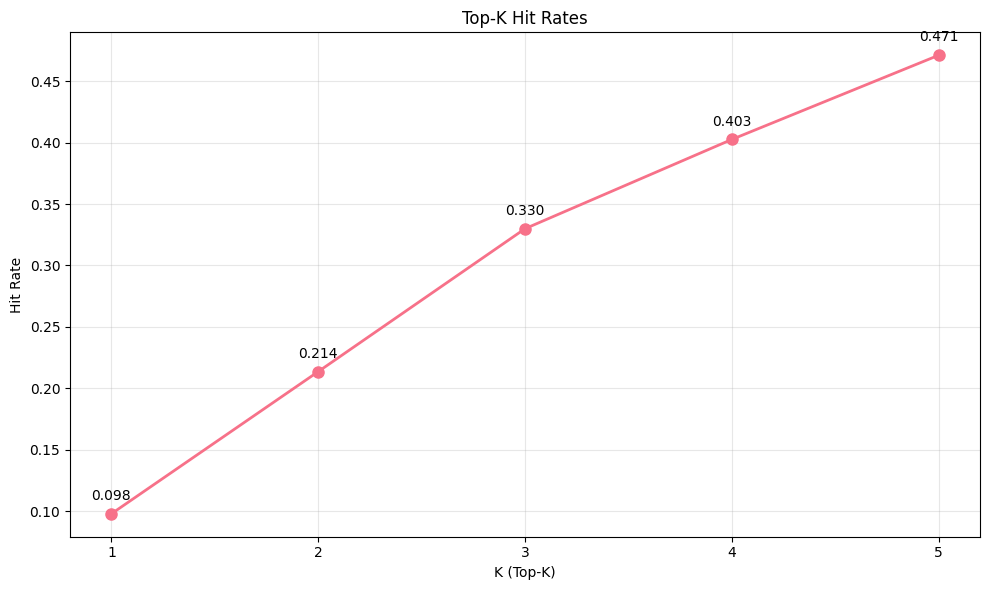

In [6]:
# Visualize Top-K hit rates
plt.figure(figsize=(10, 6))
k_values = list(range(1, 6))
rates = [hit_rates[f'Top-{k}'] for k in k_values]

plt.plot(k_values, rates, marker='o', linewidth=2, markersize=8)
plt.xlabel('K (Top-K)')
plt.ylabel('Hit Rate')
plt.title('Top-K Hit Rates')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Add value labels on points
for k, rate in zip(k_values, rates):
    plt.annotate(f'{rate:.3f}', (k, rate), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## 3. MRR (Mean Reciprocal Rank) per Year

In [7]:
def calculate_mrr(df):
    """Calculate Mean Reciprocal Rank"""
    reciprocal_ranks = []
    
    for _, row in df.iterrows():
        predictions = row['prediction']
        ground_truth = row['ground_truth']
        
        if predictions:
            try:
                rank = predictions.index(ground_truth) + 1  # 1-indexed rank
                reciprocal_ranks.append(1.0 / rank)
            except ValueError:
                reciprocal_ranks.append(0.0)  # Ground truth not in predictions
    
    return np.mean(reciprocal_ranks) if reciprocal_ranks else 0

# Calculate overall MRR
overall_mrr = calculate_mrr(df_success)
print(f"Overall MRR: {overall_mrr:.4f}")

# Try to extract year information if available in the data
# This assumes there might be year information in card_id or we need to add a year column
print("\nNote: To calculate MRR per year, we need year information in the dataset.")
print("If you have year data, please add a 'year' column to the CSV file.")

# Check if there's any pattern in card_id that might indicate year
sample_card_ids = df_success['card_id'].head(10).tolist()
print(f"\nSample card IDs (to check for year patterns): {sample_card_ids}")

Overall MRR: 0.2264

Note: To calculate MRR per year, we need year information in the dataset.
If you have year data, please add a 'year' column to the CSV file.

Sample card IDs (to check for year patterns): ['040002523F3885', '04000E523F3885', '040005523F3885', '040071523F3881', '04005A523F3881', '040006523F3885', '04007D523F3881', '040065523F3881', '040089523F3881', '040001523F3885']


MRR per Year:
2014: 0.2247
2016: 0.2280


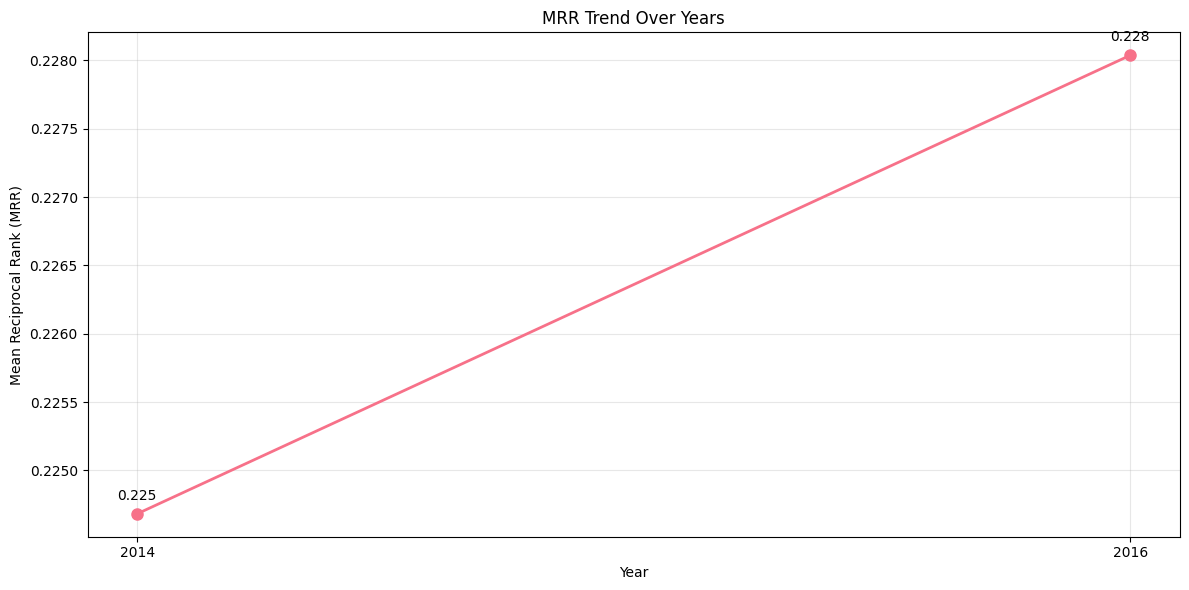

In [8]:
# If year column exists or can be extracted, calculate MRR per year
# Example implementation assuming year column exists:

if 'year' in df_success.columns:
    mrr_by_year = {}
    for year in df_success['year'].unique():
        year_data = df_success[df_success['year'] == year]
        mrr_by_year[year] = calculate_mrr(year_data)
    
    print("MRR per Year:")
    for year, mrr in sorted(mrr_by_year.items()):
        print(f"{year}: {mrr:.4f}")
    
    # Visualize MRR by year
    plt.figure(figsize=(12, 6))
    years = sorted(mrr_by_year.keys())
    mrr_values = [mrr_by_year[year] for year in years]
    
    plt.plot(years, mrr_values, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Year')
    plt.ylabel('Mean Reciprocal Rank (MRR)')
    plt.title('MRR Trend Over Years')
    plt.grid(True, alpha=0.3)
    
    for year, mrr in zip(years, mrr_values):
        plt.annotate(f'{mrr:.3f}', (year, mrr), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Year column not found. Add year information to calculate MRR per year.")

## 4. Worst Performing Pairs

In [9]:
def analyze_worst_performing_pairs(df, min_occurrences=5):
    """Analyze worst performing current_poi -> ground_truth pairs"""
    pair_stats = defaultdict(lambda: {'total': 0, 'correct': 0, 'top5_hits': 0})
    
    for _, row in df.iterrows():
        current_poi = row['current_poi']
        ground_truth = row['ground_truth']
        predictions = row['prediction']
        
        pair = (current_poi, ground_truth)
        pair_stats[pair]['total'] += 1
        
        if predictions:
            # Check top-1 accuracy
            if len(predictions) > 0 and predictions[0] == ground_truth:
                pair_stats[pair]['correct'] += 1
            
            # Check top-5 hit
            if ground_truth in predictions[:5]:
                pair_stats[pair]['top5_hits'] += 1
    
    # Calculate accuracy for each pair
    pair_performance = []
    for pair, stats in pair_stats.items():
        if stats['total'] >= min_occurrences:
            accuracy = stats['correct'] / stats['total']
            top5_rate = stats['top5_hits'] / stats['total']
            pair_performance.append({
                'current_poi': pair[0],
                'ground_truth': pair[1],
                'total_occurrences': stats['total'],
                'top1_accuracy': accuracy,
                'top5_hit_rate': top5_rate
            })
    
    return sorted(pair_performance, key=lambda x: x['top1_accuracy'])

worst_pairs = analyze_worst_performing_pairs(df_success)

print(f"Worst Performing Pairs (minimum {5} occurrences):")
print("=" * 80)

for i, pair in enumerate(worst_pairs[:15]):
    print(f"{i+1:2d}. {pair['current_poi']} → {pair['ground_truth']}")
    print(f"    Occurrences: {pair['total_occurrences']}")
    print(f"    Top-1 Accuracy: {pair['top1_accuracy']:.3f} ({pair['top1_accuracy']*100:.1f}%)")
    print(f"    Top-5 Hit Rate: {pair['top5_hit_rate']:.3f} ({pair['top5_hit_rate']*100:.1f}%)")
    print()

Worst Performing Pairs (minimum 5 occurrences):
 1. Palazzo della Ragione → Castelvecchio
    Occurrences: 1289
    Top-1 Accuracy: 0.000 (0.0%)
    Top-5 Hit Rate: 0.001 (0.1%)

 2. Duomo → Santa Anastasia
    Occurrences: 1401
    Top-1 Accuracy: 0.000 (0.0%)
    Top-5 Hit Rate: 0.729 (72.9%)

 3. Giardino Giusti → Centro Fotografia
    Occurrences: 24
    Top-1 Accuracy: 0.000 (0.0%)
    Top-5 Hit Rate: 0.042 (4.2%)

 4. Duomo → Castelvecchio
    Occurrences: 5142
    Top-1 Accuracy: 0.000 (0.0%)
    Top-5 Hit Rate: 0.000 (0.0%)

 5. Castelvecchio → Tomba Giulietta
    Occurrences: 2545
    Top-1 Accuracy: 0.000 (0.0%)
    Top-5 Hit Rate: 0.002 (0.2%)

 6. Casa Giulietta → San Zeno
    Occurrences: 498
    Top-1 Accuracy: 0.000 (0.0%)
    Top-5 Hit Rate: 0.000 (0.0%)

 7. Santa Anastasia → Castelvecchio
    Occurrences: 2374
    Top-1 Accuracy: 0.000 (0.0%)
    Top-5 Hit Rate: 0.000 (0.0%)

 8. Duomo → Tomba Giulietta
    Occurrences: 1471
    Top-1 Accuracy: 0.000 (0.0%)
    Top-5 

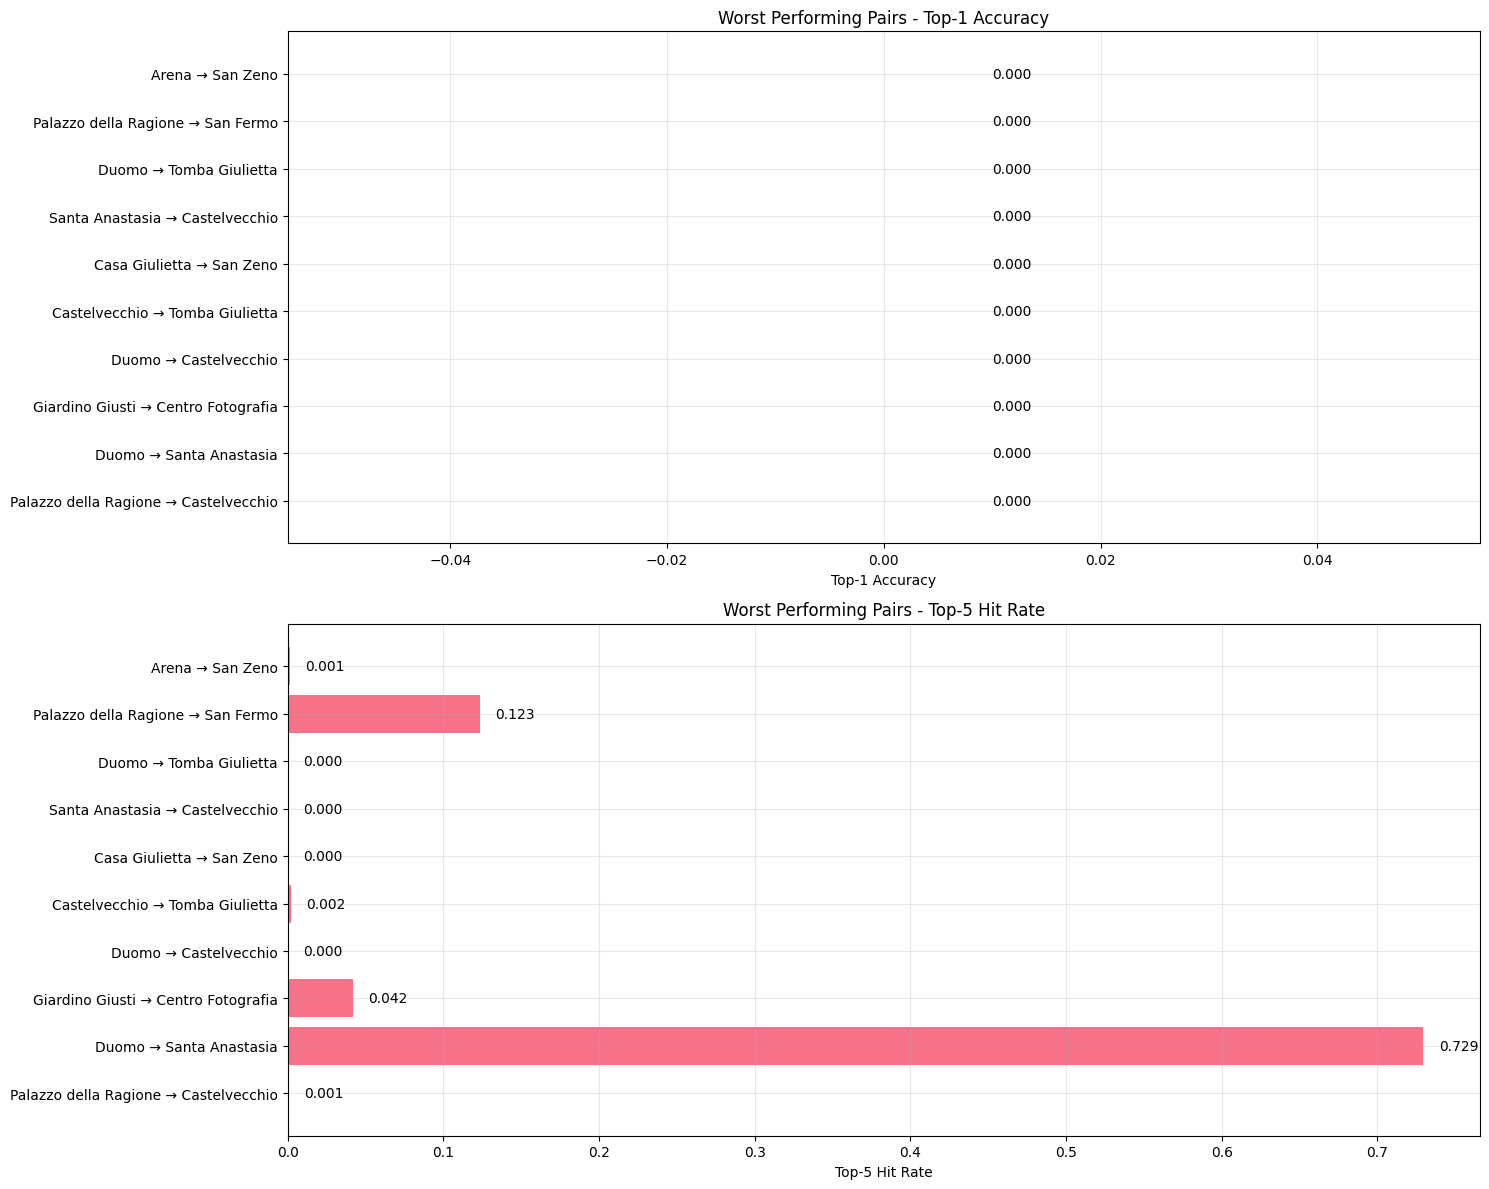

In [10]:
# Visualize worst performing pairs
if len(worst_pairs) >= 10:
    worst_10 = worst_pairs[:10]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Top-1 Accuracy
    pair_labels = [f"{p['current_poi']} → {p['ground_truth']}" for p in worst_10]
    accuracies = [p['top1_accuracy'] for p in worst_10]
    
    bars1 = ax1.barh(range(len(pair_labels)), accuracies)
    ax1.set_yticks(range(len(pair_labels)))
    ax1.set_yticklabels(pair_labels)
    ax1.set_xlabel('Top-1 Accuracy')
    ax1.set_title('Worst Performing Pairs - Top-1 Accuracy')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
        ax1.text(acc + 0.01, i, f'{acc:.3f}', va='center')
    
    # Top-5 Hit Rate
    hit_rates = [p['top5_hit_rate'] for p in worst_10]
    
    bars2 = ax2.barh(range(len(pair_labels)), hit_rates)
    ax2.set_yticks(range(len(pair_labels)))
    ax2.set_yticklabels(pair_labels)
    ax2.set_xlabel('Top-5 Hit Rate')
    ax2.set_title('Worst Performing Pairs - Top-5 Hit Rate')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, rate) in enumerate(zip(bars2, hit_rates)):
        ax2.text(rate + 0.01, i, f'{rate:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

## 5. Confusion Matrix

In [11]:
# Create confusion matrix for most common POIs
def create_confusion_matrix(df, top_n_pois=15):
    """Create confusion matrix for top N most common POIs"""
    
    # Get most common POIs from ground truth
    poi_counts = df['ground_truth'].value_counts()
    top_pois = poi_counts.head(top_n_pois).index.tolist()
    
    # Filter data to include only top POIs
    df_filtered = df[df['ground_truth'].isin(top_pois)].copy()
    
    # Get top-1 predictions
    df_filtered['top1_prediction'] = df_filtered['prediction'].apply(
        lambda x: x[0] if x and len(x) > 0 else 'NO_PREDICTION'
    )
    
    # Create confusion matrix
    y_true = df_filtered['ground_truth']
    y_pred = df_filtered['top1_prediction']
    
    # Get unique labels (combination of true and predicted)
    all_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))
    
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    
    return cm, all_labels, df_filtered

cm, labels, df_filtered = create_confusion_matrix(df_success)

print(f"Confusion Matrix created for {len(labels)} POIs")
print(f"Matrix shape: {cm.shape}")
print(f"Filtered dataset size: {len(df_filtered)} samples")

Confusion Matrix created for 22 POIs
Matrix shape: (22, 22)
Filtered dataset size: 135343 samples


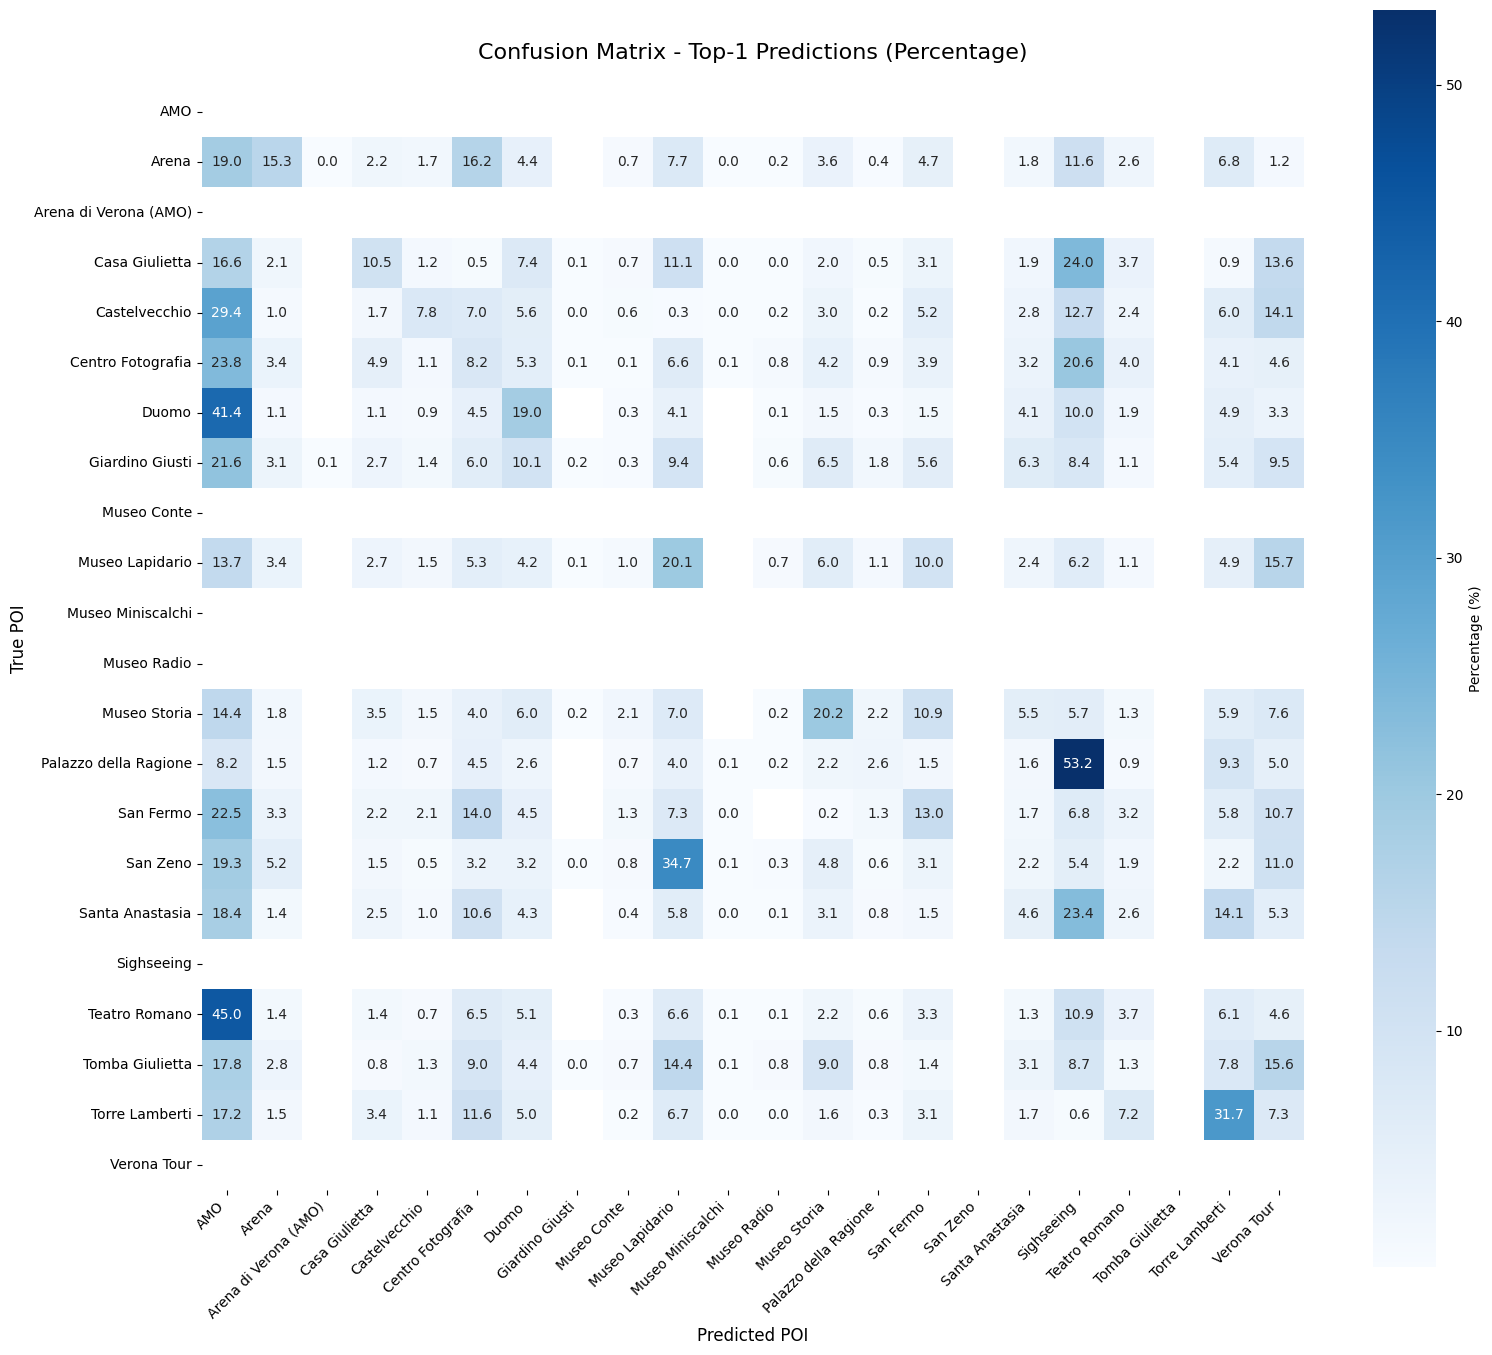

In [12]:
# Visualize confusion matrix
plt.figure(figsize=(16, 14))

# Calculate percentages for better interpretation
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent = np.nan_to_num(cm_percent)  # Replace NaN with 0

# Create heatmap
mask = cm == 0  # Mask zero values for better visualization
sns.heatmap(cm_percent, 
            xticklabels=labels, 
            yticklabels=labels,
            annot=True, 
            fmt='.1f',
            cmap='Blues',
            mask=mask,
            square=True,
            cbar_kws={'label': 'Percentage (%)'})

plt.title('Confusion Matrix - Top-1 Predictions (Percentage)', fontsize=16, pad=20)
plt.xlabel('Predicted POI', fontsize=12)
plt.ylabel('True POI', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

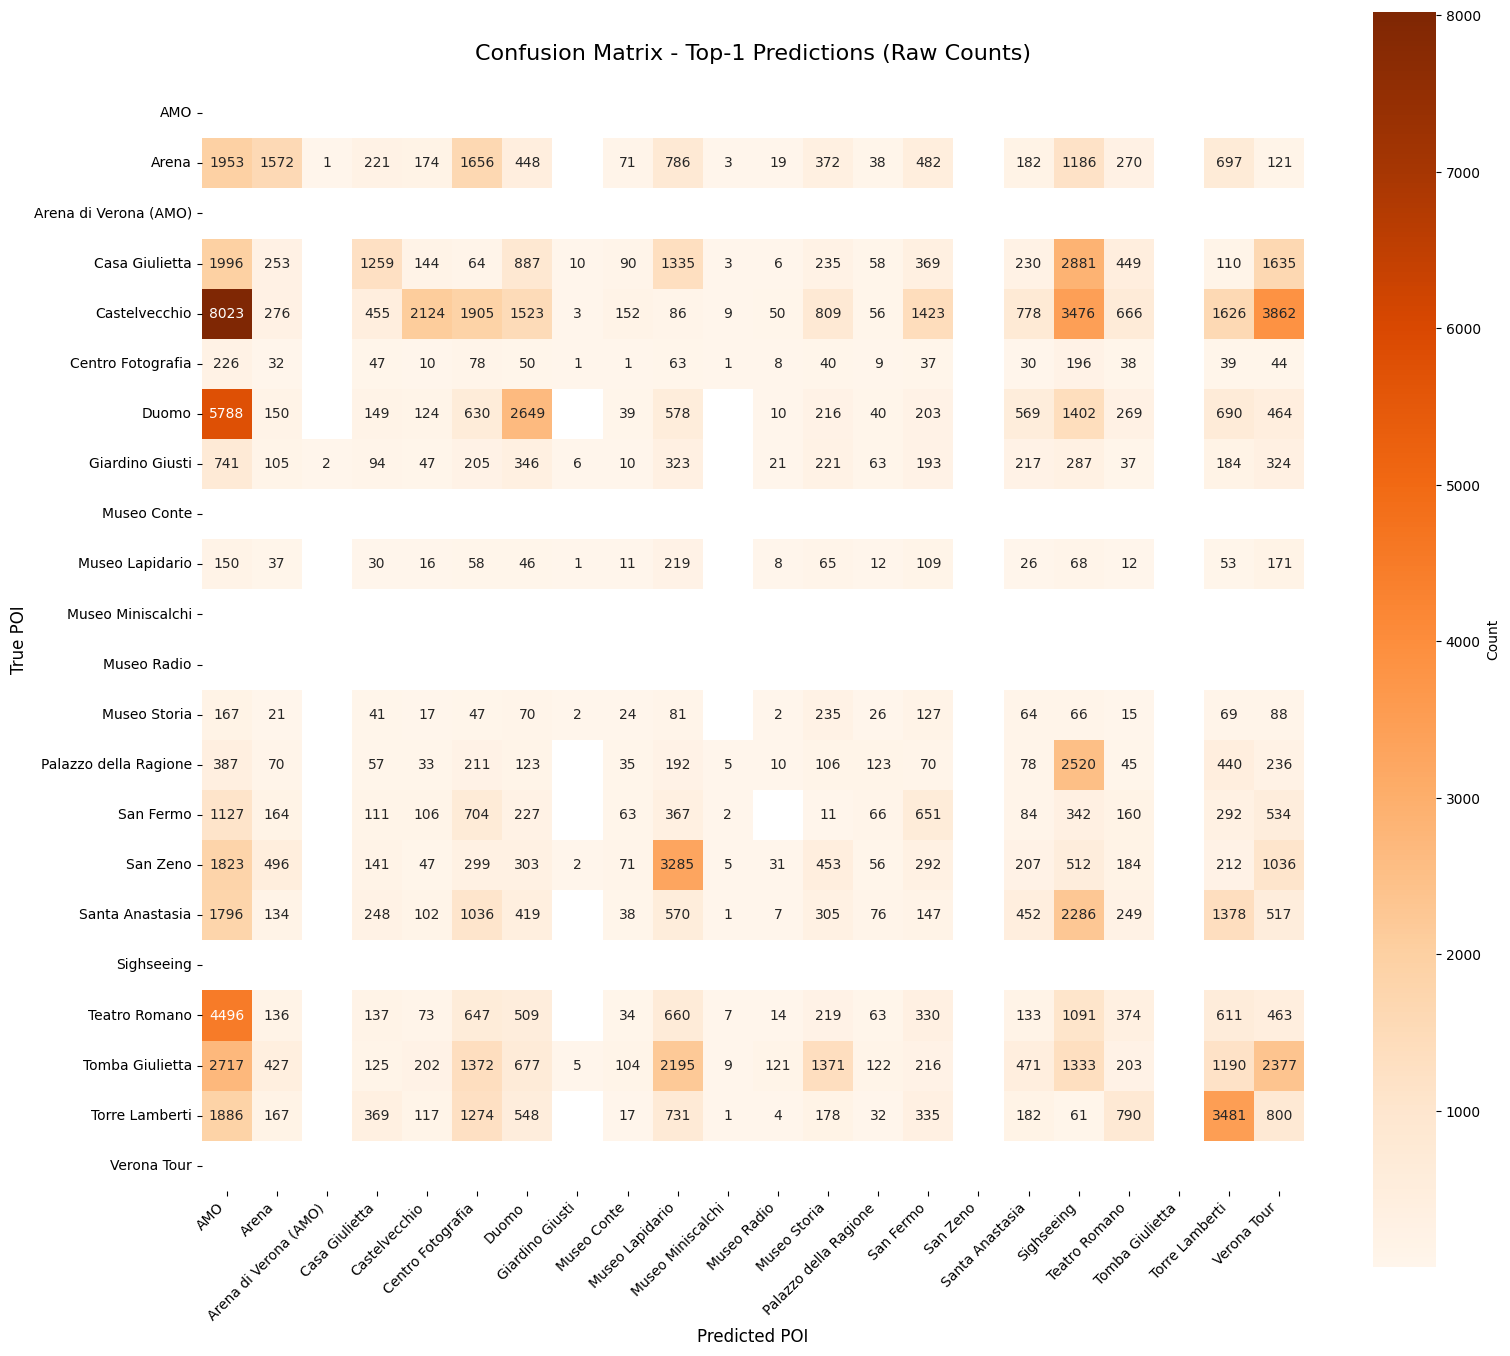

In [13]:
# Alternative confusion matrix with raw counts
plt.figure(figsize=(16, 14))

mask = cm == 0
sns.heatmap(cm, 
            xticklabels=labels, 
            yticklabels=labels,
            annot=True, 
            fmt='d',
            cmap='Oranges',
            mask=mask,
            square=True,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Top-1 Predictions (Raw Counts)', fontsize=16, pad=20)
plt.xlabel('Predicted POI', fontsize=12)
plt.ylabel('True POI', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Summary Statistics

In [14]:
print("=" * 60)
print("COMPREHENSIVE STATISTICS SUMMARY")
print("=" * 60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total records: {len(df):,}")
print(f"   • Successful predictions: {len(df_success):,} ({len(df_success)/len(df)*100:.1f}%)")
print(f"   • Unique cards: {df_success['card_id'].nunique():,}")
print(f"   • Unique POIs: {df_success['ground_truth'].nunique()}")
print(f"   • Average processing time: {df_success['processing_time'].mean():.2f}s")

print(f"\n🎯 ACCURACY METRICS:")
print(f"   • Top-1 Accuracy: {top1_accuracy:.4f} ({top1_accuracy*100:.2f}%)")
print(f"   • Top-5 Hit Rate: {top5_hit_rate:.4f} ({top5_hit_rate*100:.2f}%)")
print(f"   • Mean Reciprocal Rank (MRR): {overall_mrr:.4f}")

print(f"\n📈 TOP-K PERFORMANCE:")
for k, rate in hit_rates.items():
    print(f"   • {k} Hit Rate: {rate:.4f} ({rate*100:.2f}%)")

print(f"\n⚠️  WORST PERFORMING PAIRS:")
for i, pair in enumerate(worst_pairs[:5]):
    print(f"   {i+1}. {pair['current_poi']} → {pair['ground_truth']}")
    print(f"      Accuracy: {pair['top1_accuracy']:.3f}, Occurrences: {pair['total_occurrences']}")

print(f"\n🔍 CONFUSION MATRIX INFO:")
print(f"   • Matrix size: {cm.shape[0]}×{cm.shape[1]}")
print(f"   • POIs analyzed: {len(labels)}")
print(f"   • Samples in matrix: {len(df_filtered):,}")

diagonal_sum = np.diag(cm).sum()
total_predictions = cm.sum()
matrix_accuracy = diagonal_sum / total_predictions if total_predictions > 0 else 0
print(f"   • Matrix accuracy: {matrix_accuracy:.4f} ({matrix_accuracy*100:.2f}%)")

print("\n" + "=" * 60)

COMPREHENSIVE STATISTICS SUMMARY

📊 DATASET OVERVIEW:
   • Total records: 136,155
   • Successful predictions: 136,153 (100.0%)
   • Unique cards: 136,153
   • Unique POIs: 22
   • Average processing time: 2.72s

🎯 ACCURACY METRICS:
   • Top-1 Accuracy: 0.0980 (9.80%)
   • Top-5 Hit Rate: 0.4710 (47.10%)
   • Mean Reciprocal Rank (MRR): 0.2264

📈 TOP-K PERFORMANCE:


AttributeError: 'list' object has no attribute 'items'